**Note:** Please ensure you have the correct credentials files provided by me via slack message (should be titled "config.json" when you receive it from me) - Please create a folder titled Credentials and place the "config.json" file under it so your API call will be successful.

Activate Python virtual environment first and install all packages before running the notebook.

1. create a new virtual environment
```
python -m venv venv
```

2. activate the virtual environment
```
source venv/Scripts/activate
```

3. install packages
```
pip install -r requirements.txt
```

4. make sure your kernel is switched to the venv python kernel






Setting up connection to Google BigQuery in order to get bitcoin blocks data and bitcoin transactions data - the two datasource for this project. 

In [67]:
from google.cloud import bigquery
import os
#Set the environement variable for key file (telling python where my login key file is)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "Credentials/config.json"
#Start the BigQuery client using my key
client = bigquery.Client()



In [68]:
# Running a query on the table "crypto_bitcoin.blocks" to check the datatype of each column

query_sample = """
SELECT *
FROM `bigquery-public-data.crypto_bitcoin.blocks`
LIMIT 5
"""

df_sample = client.query(query_sample).to_dataframe()
df_sample.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   hash               5 non-null      object             
 1   size               5 non-null      Int64              
 2   stripped_size      5 non-null      Int64              
 3   weight             5 non-null      Int64              
 4   number             5 non-null      Int64              
 5   version            5 non-null      Int64              
 6   merkle_root        5 non-null      object             
 7   timestamp          5 non-null      datetime64[us, UTC]
 8   timestamp_month    5 non-null      dbdate             
 9   nonce              5 non-null      object             
 10  bits               5 non-null      object             
 11  coinbase_param     5 non-null      object             
 12  transaction_count  5 non-null      Int64              

By checking the daterange of the crypto_bitcoin.blocks table, I made sure the timeperiod I'm interested in was covered in the dataset.
The output was:
	start_date	end_date
0	2009-01-03 18:15:05+00:00	2025-08-06 02:10:59+00:00
Meaning the dataset contains information from 2009~Present.

In [69]:
# Checking if the new table "crypto_bitcoin.blocks" has information for the timeperiod I'm looking for:
query_check_range = """
SELECT
  MIN(timestamp) AS start_date,
  MAX(timestamp) AS end_date
FROM `bigquery-public-data.crypto_bitcoin.blocks`
"""

df_range = client.query(query_check_range).to_dataframe()
df_range

,start_date,end_date
0,2009-01-03 18:15:05+00:00,2025-08-06 02:10:59+00:00


Next, I checked if the transactions table contained the data from the time period (March 2020) I was interested in, and checked how many rows that would be.

query_row_count = """
SELECT COUNT(*) as transaction_count
FROM `bigquery-public-data.crypto_bitcoin.transactions`
WHERE block_timestamp BETWEEN '2020-03-01' AND '2020-03-31'
"""
df_row_count = client.query(query_row_count).to_dataframe()
print(df_row_count)

The output was:
transaction_count
0            8613976
The above count revealed there were 8.6M transactions in the bitcoin transactions table belonging to the month of March 2020. Due to performance issues, I decided to extract a sample of 100,000 rows of transactions data to use for my project. 

In [70]:
# Checking to make sure there's enough data during March 2020 in the transactions table:
query_row_count = """
SELECT COUNT(*) as transaction_count
FROM `bigquery-public-data.crypto_bitcoin.transactions`
WHERE block_timestamp BETWEEN '2020-03-01' AND '2020-03-31'
"""
df_row_count = client.query(query_row_count).to_dataframe()
print(df_row_count)

   transaction_count
0            8613976


After confirming the transactions table contains enough rows of information, I ran the following query to get the columns and datatype of the data within the table:

In [71]:
# Getting a sample (100k rows) of data from the bitcoin transactions table for March 2020 and getting the column and datatype information:
query_transactions_march_2020 = """
SELECT *
FROM `bigquery-public-data.crypto_bitcoin.transactions`
WHERE block_timestamp BETWEEN '2020-03-01' AND '2020-03-31 23:59:59'
LIMIT 100000
"""
df_transactions = client.query(query_transactions_march_2020).to_dataframe()
df_transactions.info()
df_transactions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   hash                   100000 non-null  object             
 1   size                   100000 non-null  Int64              
 2   virtual_size           100000 non-null  Int64              
 3   version                100000 non-null  Int64              
 4   lock_time              100000 non-null  Int64              
 5   block_hash             100000 non-null  object             
 6   block_number           100000 non-null  Int64              
 7   block_timestamp        100000 non-null  datetime64[us, UTC]
 8   block_timestamp_month  100000 non-null  dbdate             
 9   input_count            100000 non-null  Int64              
 10  output_count           100000 non-null  Int64              
 11  input_value            99942 non-null   

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,b864c54441c6bd3da97e447f6054dd89a87bf124b95ec5...,289,262,2,0,000000000000000000014c1c4f6e71d67229af76bd90b4...,621537,2020-03-13 23:41:47+00:00,2020-03-01,0,3,None,1309872258.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
1,0a07476694c6131502b08620076268b29d62ed4c890775...,290,263,1,0,0000000000000000000e75b80a3c386786b382487615f3...,623629,2020-03-30 16:13:31+00:00,2020-03-01,0,3,None,1265923490.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
2,bd6fce8d62ad1416499bbf3153c447ac2b0ef343d24dc6...,296,269,2,0,00000000000000000003f17e623aa1fbe4213977d72d60...,619771,2020-03-02 02:03:23+00:00,2020-03-01,0,3,None,1250187316.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': 'OP_HASH160 5885ab..."
3,882b18655a3101c78f0e2398a598dfa55d5726e79e287a...,339,312,2,0,000000000000000000088d2e692d59df218991c3b64880...,621087,2020-03-10 13:42:56+00:00,2020-03-01,0,4,None,1280120781.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': '0 97cfc76442fe717..."
4,d396c7a682fe8c313323eb0758dfb33a46ce1ba56986f0...,342,315,2,0,0000000000000000000f9bc4c47d970859fc6185533d74...,622987,2020-03-26 09:40:33+00:00,2020-03-01,0,4,None,1282274093.000000000,True,0E-9,[],"[{'index': 0, 'script_asm': '0 97cfc76442fe717..."


To confirm df_transactions contained data from 03/01/2020 to 03/31/2020, I ran a print of min and max of the value present in the column "block_timestamp".

In [72]:
print(df_transactions['block_timestamp'].min(), df_transactions['block_timestamp'].max())

2020-03-01 00:04:03+00:00 2020-03-31 23:51:06+00:00


In [74]:
# SQLite start
import sqlite3


In [75]:
# Connecting to a new SQLite database to create a file for my dataset
connection = sqlite3.connect("bitcoin_data.db")

In [ ]:
# Saving the blocks DataFrame into the bitcoin_data.db database as a new table called "blocks"
table_name = "blocks"

query_blocks_covid = """
SELECT *
FROM `bigquery-public-data.crypto_bitcoin.blocks`
WHERE timestamp BETWEEN '2020-03-01' AND '2020-03-31'
"""
df_blocks = client.query(query_blocks_covid).to_dataframe()
df_blocks.info()

data = df_blocks
# Writing the data in df_blocks to the database
data.to_sql(
        name = table_name,
        con = connection,
        if_exists = "replace",
        index = False
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26253 entries, 0 to 26252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   hash               26253 non-null  object             
 1   size               26253 non-null  Int64              
 2   stripped_size      26253 non-null  Int64              
 3   weight             26253 non-null  Int64              
 4   number             26253 non-null  Int64              
 5   version            26253 non-null  Int64              
 6   merkle_root        26253 non-null  object             
 7   timestamp          26253 non-null  datetime64[us, UTC]
 8   timestamp_month    26253 non-null  dbdate             
 9   nonce              26253 non-null  object             
 10  bits               26253 non-null  object             
 11  coinbase_param     26253 non-null  object             
 12  transaction_count  26253 non-null  Int64      

26253

In [ ]:
# Feature engineering 1 - Converting block timestamp row to extract an hour within the day time column
# This is to extract the transaction hour out of the timestamp column within the same table
df_transactions['tx_hour'] = df_transactions['block_timestamp'].dt.hour

In [79]:
# Feature engineering 2 - extracting the fee_rate of the individual transactions that took place out of the 100K rows of transactions that were isolated for the dataset
# This is to calculate the efficiency (how much the sender spent in total BTC amount to send the intended amount of BTC to the recipient): This extracts the "fee rate" or the % amount of BTC paid to the miner in that transaction
# df_transactions['fee_rate'] = df_transactions['fee'] / df_transactions['input_value']
# Since there were small number of rows that returned the value "None" in the "input_value" I modified my code to avoid dividing by 0 or "None"
def calculate_fee_rate(row):
    fee = row['fee']
    input_value = row['input_value']
    
    if input_value in [0, None]:  # To avoid divide by 0 or None
        return None
    else:
        return fee / input_value

df_transactions['fee_rate'] = df_transactions.apply(calculate_fee_rate, axis=1)

In [ ]:
# Feature engineering 3 - extracting the value difference the individual transactions that took place out of the 100K rows of transactions that were isolated for the dataset
# This is to calculate the difference in the total BTC amount the sender spent and the total amount of BTC the recipient received. This is calculated to isolate the "fee" or the amount of BTC paid to the miner in that transaction.
# df_transactions['value_diff'] = df_transactions['output_value'] - df_transactions['input_value']
# Since there were small number of rows that returned the value "None" in the "input_value" I modified my code to avoid calculation that uses "None" 
def calculate_value_diff(row):
    input_val = row['input_value']
    output_val = row['output_value']
    
    if input_val is None or output_val is None:
        return None
    else:
        return output_val - input_val

df_transactions['value_diff'] = df_transactions.apply(calculate_value_diff, axis=1)

In [81]:
df_transactions[['input_value', 'output_value', 'value_diff']].head(10)

,input_value,output_value,value_diff
0,None,1309872258.000000000,None
1,None,1265923490.000000000,None
2,None,1250187316.000000000,None
3,None,1280120781.000000000,None
4,None,1282274093.000000000,None
5,None,1253422181.000000000,None
6,None,1304526409.000000000,None
7,None,1257328612.000000000,None
8,3693927813.000000000,3693924778.000000000,-3035.000000000
9,270000.000000000,256748.000000000,-13252.000000000


In [ ]:
# visualization 1 - average fee rate by hour of day
# When during the day are bitcoin transactions most expensive relative to the size of transactions? "Expensive" in this context means more fees paid to the miner for the total value bitcoin the sender spent.
# 1st step is to group the transactions by hour of the day and obtain the average fee rate incurred during that timeslot
fee_by_hour = df_transactions.groupby('tx_hour')['fee_rate'].mean().reset_index()
# It should mean that my dataframe now contains a row per each hour of the day (0~23), AND contains the average fee_rate for all transactions that occurred during that hour

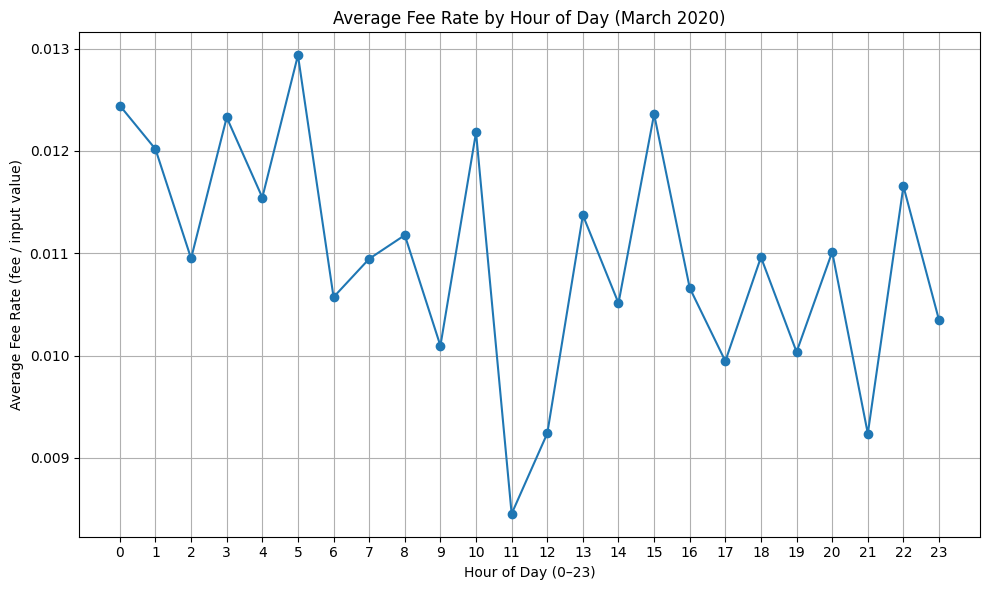

In [83]:
# Plotting average fee rate by hour

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(fee_by_hour['tx_hour'], fee_by_hour['fee_rate'], marker='o', linestyle='-')
plt.title('Average Fee Rate by Hour of Day (March 2020)')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Average Fee Rate (fee / input value)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

Average fee rate by hour of day during March 2020 line chart
observations:
1. Peak fee rates appear between hours 3-6 (US EST 10PM~1AM)
2. Notable spike at hour 20

Note:The hour of day uses UTC time (UTC is known as the "Coordinated Universal Time), which is is the primary time standard globally used to regulate clocks and time (source: wikipedia). 



Overall Observation: On its own, the average fee rate by hour did not reveal a consistent pattern. If bitcoin blockchain users were concentrated in specific areas of the world, we might expect average fee rate by hour to follow a predictable daily cycle (For example, if bitcoin users were mostly located in China, fee rates might peak consistently between 9AM and 9 PM China Standard time). However, my finding shows there were spikes and dips throughout the day which suggests a more globally distributed and decentralized user base. 

In [84]:
# Visualization 2- Average value difference between input_total and output_total by hour
# This shows certain times of the day users are likely to overpay or underpay the miner (while ignoring the "None" value on the "input_total" column)

value_diff_by_hour = df_transactions.groupby('tx_hour')['value_diff'].mean().reset_index()
# It should mean that my dataframe now contains a row per each hour of the day (0~23), AND contains the average value differnce for all transactions that occurred during that hour

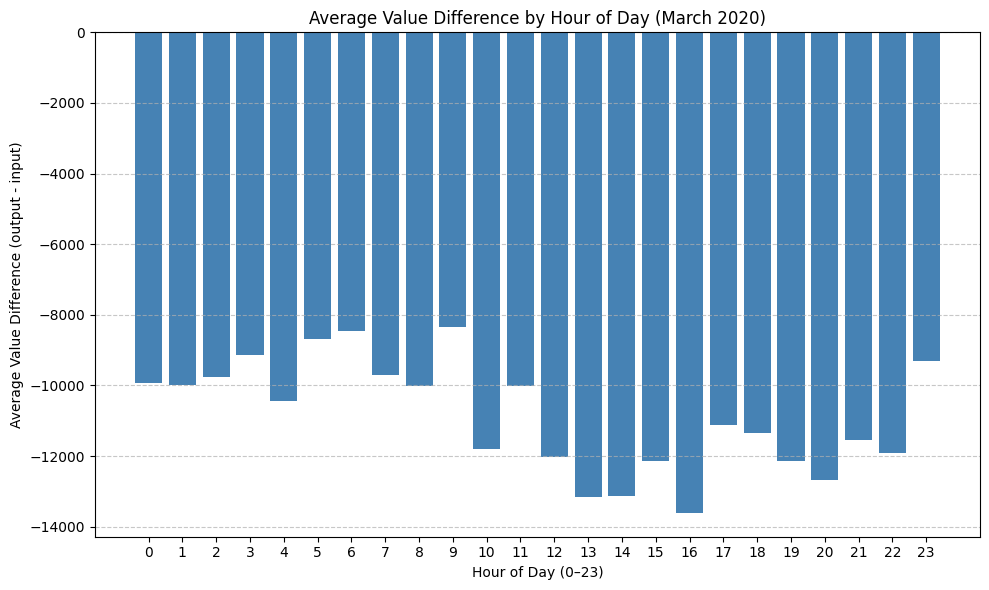

In [85]:
# Creating a bar graph of the value_diff by hour of the day
plt.figure(figsize=(10, 6))
plt.bar(value_diff_by_hour['tx_hour'], value_diff_by_hour['value_diff'], color='steelblue')
plt.title('Average Value Difference by Hour of Day (March 2020)')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Average Value Difference (output - input)')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Observations:
1. hours 13-17 show larger value_diff transactions during this time paid the highest fees compared to any other time of the day suggesting hours 13-17 were the most busy hour for the bitcoin blockchain AND/OR hours 13-17 tended to have larger transaction values compared to other hours of the day.
2. hours 0,4,23 show smaller value_diff, suggesting the queue of transactions was less congested during this time OR the individual transaction values were smaller compared to other hours of the day.
3. unlike fee rate by hour (Visual 1), we can roughly see a step-like pattern where we can group the hours in to two groups: Hours 10-22 is one group where the average fees are consistently in the 10,000 Satoshi's (smallest unit of bitcoin) and above compared to hours 23-9 where the fees stay in the 8,000 to 10,000 Satoshi's range. 


Overall Observation: Surprisingly, the average fee rate by hour (Visual 1) and the average fee by hour (Visual 2) did not exhibit a strong correlation. This suggests that raw transaction fees alone may not reliably indicate periods of network congestion. 
Assuming the blockchain users are economical and rational actors, they are concerned with minimizing the fees relative to the total amount of value they are sending(i.e. fee rate). For this reason, I placed greater analytical weight on the patterns observed in fee rate.
The lack of consistent patterns observed in fee rate per hour of day and fee per hour of day highlights the importance of using normalized metrics like fee rate instead of just looking at fees. 

Next, I tested my assumption of whether bitcoin blockchain users are actually rational actors.
To test this, I examined how fee rates are distributed across the dataset. If users are rational actors, the fee rates should corroborate this if we find most transactions are clustered around a narrow range of fee rates, which is just high enough to be accepted by miners, but no higher than necessary. 

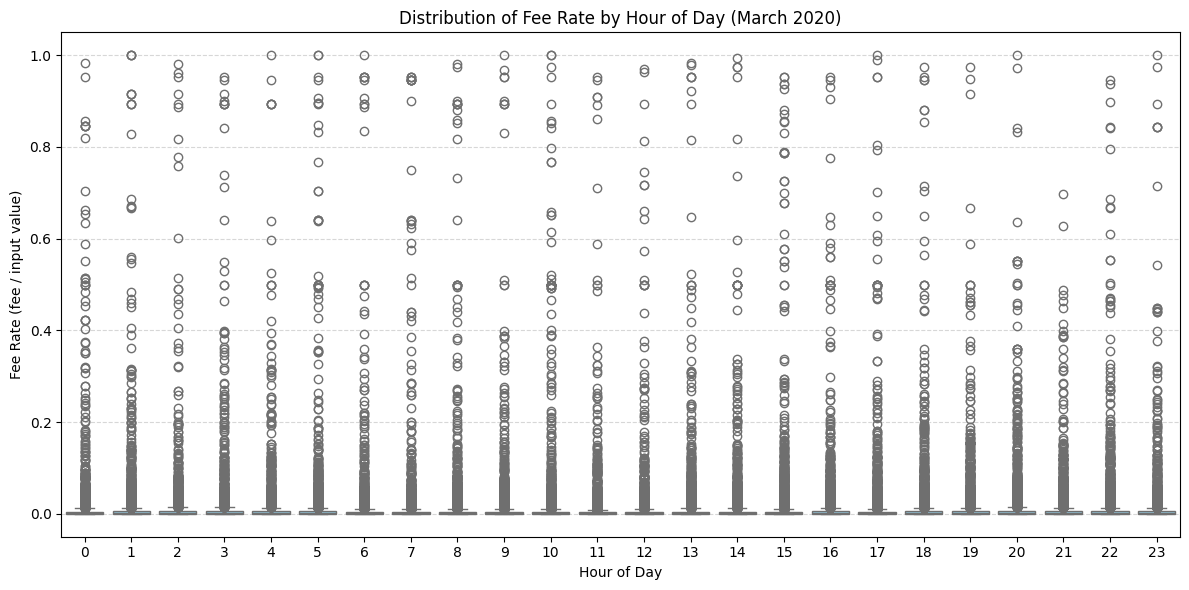

In [86]:
# Making a boxplot of fee_rate by hour to see the spread and consistency of fee rates throughout the day
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_transactions, x='tx_hour', y='fee_rate', color='skyblue')
plt.title('Distribution of Fee Rate by Hour of Day (March 2020)')
plt.xlabel('Hour of Day')
plt.ylabel('Fee Rate (fee / input value)')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Observations:
1. A fee rate between 0.2 and 1.0 indicates that the sender paid 20% to 100% of the total transaction value as a fee.
2. Transactions with such high fee rates are likely attributable to one or more of the following: 

A. Extremely small transactions

B.User error in setting the fee they are willing to pay 

C. High urgency transactions where the user was willing to pay very high fees for immediate confirmation 

D. Potential spam or attack attempts by participants who wish to cause artificial congestion in the network

3. Regardless of the cause, they are economically irrational transactions from a cost-efficiency standpoint.



Overall observation: The presence of high fee rate transactions suggest that irrational or non-economical behavior does occur on the network, but the boxplot shows taht such cases are relatively rare. The majorigy of transactions seem to cluster tightly around much lower fee rates according to this visual. This visual supports the assumption that most users behave rationally. As a result, I treated the higher rates as outliers/anomalies and chose to refine the visualization by focusing on the range of values where most fee rates are concentrated.

For the refined visual, refer to below:

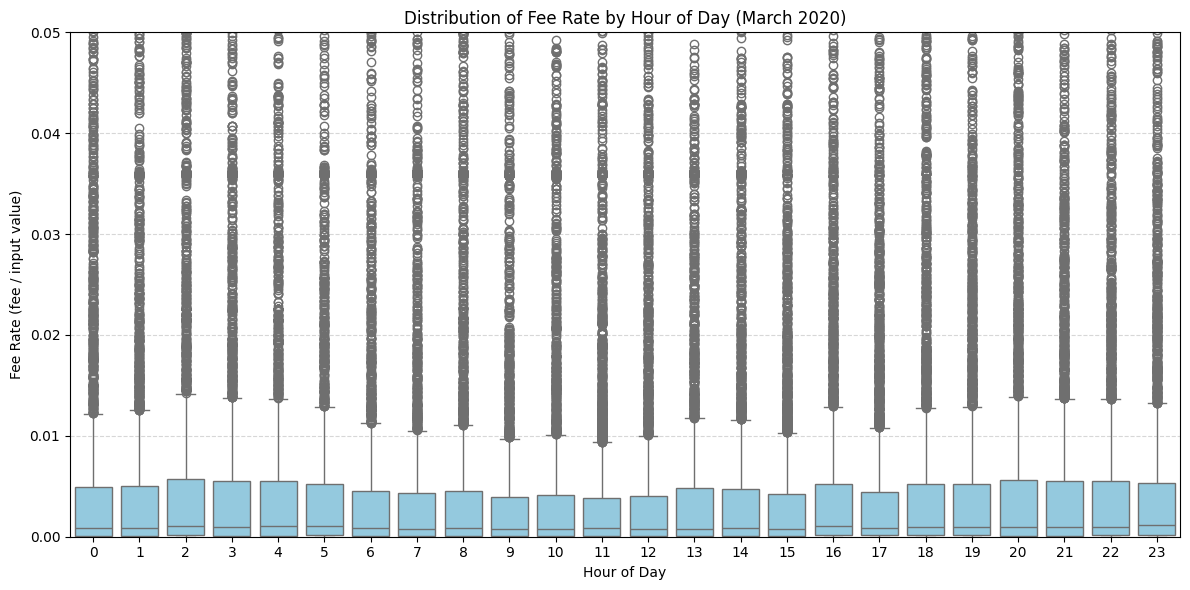

In [87]:
#creating a new boxplot with trimmed Y-axis, which will put transactions above 5% into the category of outliers

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_transactions, x='tx_hour', y='fee_rate', color='skyblue')
plt.ylim(0, 0.05)  # Trim y-axis to focus on the bulk of values
plt.title('Distribution of Fee Rate by Hour of Day (March 2020)')
plt.xlabel('Hour of Day')
plt.ylabel('Fee Rate (fee / input value)')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Observations: Most transactions cluster around fee_rate values between 0.005 and 0.015, meaning most transaction fees were lower than 1% of the transaction value, often a lot lower. This pattern suggests that the Bitcoin network effectively enables low-cost, peer-to-peer value transfers without the need for a centralized intermediary, and that the vast majority of users behave as rational economic actors.

These findings are especially noteworthy given the timing: March 2020 marked the beginning of widespread economic disruption in the United States due to COVID-19 lockdowns. In such a context, Bitcoin’s ability to facilitate low-cost, trustless transfers underscores its resilience and relevance as an alternative financial network.  

Lastly, I joined the blocks and transactions tables to explore whether any clear patterns emerged in average transaction fees over the days of March 2020. This period was marked by significant turmoil in global financial markets (During the month of March, the United States declared a national emergency and implemented a nationwide lockdown).

This visualization aims to examine whether such real-world events had a measurable impact on activity within the Bitcoin blockchain.

In [88]:
# To save the df_transactions Dataframe to database, I needed to convert "Numeric" type column (which showed up as "decimal.Decimal" in error message) to float type.

import decimal

# Convert Decimal columns to float so SQLite can store them
for col in df_transactions.columns:
    if df_transactions[col].apply(type).eq(decimal.Decimal).any():
        df_transactions[col] = df_transactions[col].astype(float)

In [ ]:
# Saving the df_transactions DataFrame into the database as a table named "transactions"
table_name = "transactions"
data = df_transactions

# Write the data into the database connection
data.to_sql(
    name=table_name,
    con=connection,        # connection to the SQLite database
    if_exists="replace",   # if the table already exists, replace it
    index=False            # don't include the DataFrame index as a column
)

100000

In [90]:
# writing and running SQL JOIN on the two tables in my database.
# Join transactions and blocks tables using the shared field "block_number"

import pandas as pd
query = """
SELECT 
    t.hash AS transaction_id,
    t.block_number,
    t.input_value,
    t.output_value,
    t.fee,
    b.timestamp AS block_timestamp
FROM transactions t
JOIN blocks b
  ON t.block_number = b.number;
"""
df_joined = pd.read_sql_query(query, connection)
df_joined.head()

,transaction_id,block_number,input_value,output_value,fee,block_timestamp
0,b864c54441c6bd3da97e447f6054dd89a87bf124b95ec5...,621537,NaN,1.309872e+09,0.0,2020-03-13 23:41:47+00:00
1,0a07476694c6131502b08620076268b29d62ed4c890775...,623629,NaN,1.265923e+09,0.0,2020-03-30 16:13:31+00:00
2,bd6fce8d62ad1416499bbf3153c447ac2b0ef343d24dc6...,619771,NaN,1.250187e+09,0.0,2020-03-02 02:03:23+00:00
3,882b18655a3101c78f0e2398a598dfa55d5726e79e287a...,621087,NaN,1.280121e+09,0.0,2020-03-10 13:42:56+00:00
4,d396c7a682fe8c313323eb0758dfb33a46ce1ba56986f0...,622987,NaN,1.282274e+09,0.0,2020-03-26 09:40:33+00:00


Now we have a table that has been joined (blocks table & transactions table). From that new table called df_joined, we can get average transaction fee by day.

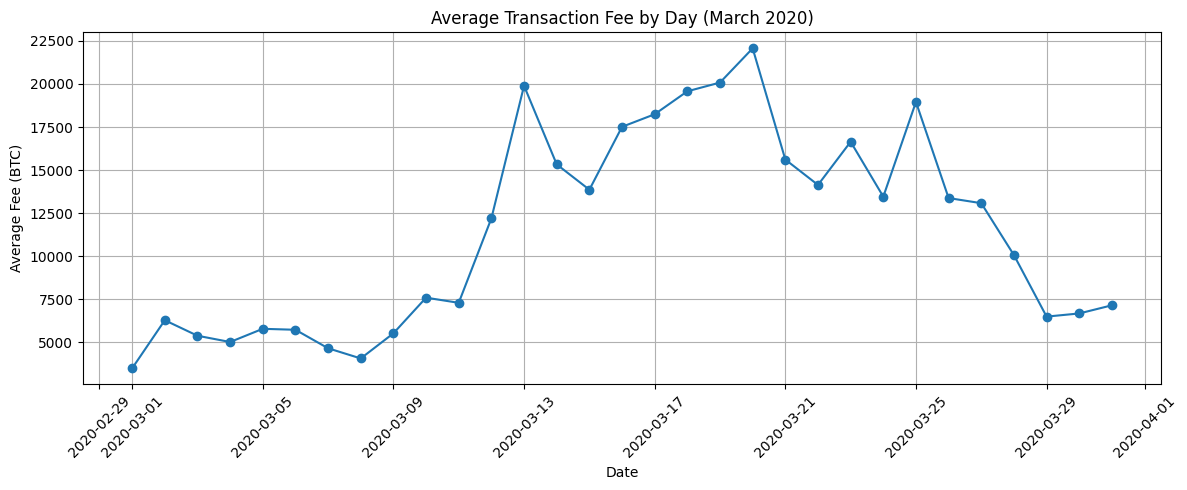

In [91]:
# Average transaction fee by day
# Convert block_timestamp to date
df_joined['block_date'] = pd.to_datetime(df_joined['block_timestamp']).dt.date

# Group by date and calculate average fee
avg_fee_by_day = df_joined.groupby('block_date')['fee'].mean().reset_index()

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(avg_fee_by_day['block_date'], avg_fee_by_day['fee'], marker='o')
plt.title('Average Transaction Fee by Day (March 2020)')
plt.xlabel('Date')
plt.ylabel('Average Fee (BTC)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Average Transaction Fee by Day line chart shows the average transaction fee per day for Bitcoin transactions in March 2020.

Observations:
1. Fees spiked sharply around March 12-13, stayed elevated for a week, then gradually decreased.
2. This spike aligns with a major market crash triggered by COVID-19 lockdown, when US initially announced they are locking down the country and economy (March 13, 2020).
3. Higher fees reflect network congestion during a surge in transaction activity, as users most likely panic sold.

Observation Summary:
The line chart of average transaction fees by day in March 2020 tells a compelling story that mirrors global financial developments outside of the Bitcoin network.

On March 13, 2020, the United States declared a national emergency and implemented a nationwide lockdown in response to the COVID-19 pandemic. This announcement triggered widespread financial turmoil, as investors scrambled to raise cash amid deepening liquidity shortages and cascading margin calls. Forced selling became self-reinforcing, leading to panic across asset classes.

During this same period, the Bitcoin network experienced elevated transaction volumes and a sharp increase in average transaction fees. Bitcoin’s price fell from approximately $10,000 in mid-February to below $4,000 in just a matter of days. The spike in transaction fees likely reflects a surge in urgent activity consistent with panic selling we saw among investors in the broader market shock.

Interactive query --> 
This is an interactive query that the user can input a date within March 1st~ March 31st to get the average transaction fees of the day.

In [92]:
# Interactive query

user_input = input("Enter a date in March 2020 (YYYY-MM-DD) to view transaction stats: ")

try:
    user_date = pd.to_datetime(user_input).date()
    df_joined['block_date'] = pd.to_datetime(df_joined['block_timestamp']).dt.date
    filtered = df_joined[df_joined['block_date'] == user_date]
    
    if not filtered.empty:
        avg_fee = filtered['fee'].mean()
        avg_fee_rate = (filtered['fee'] / filtered['input_value']).mean()
        print(f"Date: {user_date}")
        print(f"Total transactions: {len(filtered)}")
        print(f"Average fee: {avg_fee:.8f}")
        print(f"Average fee rate: {avg_fee_rate:.6f}")
    else:
        print(f"No transactions found on {user_date}.")
except:
    print("Invalid date format.Please enter a valid date in March 2020.")

Date: 2020-03-08
Total transactions: 3642
Average fee: 4073.68314113
Average fee rate: 0.006497
